In [1]:
import requests #==2.22.0==py37_1
import lxml.html as lh #==4.5.0==py37h1350720_0
import pandas as pd #==1.0.1==py37h47e9c7a_0
import numpy as np #==1.18.1==py37h93ca92e_0
import matplotlib.pyplot as plt #==3.1.3==py37_0

# ER Inspector Scraper

This notebook was created to help others utilize data stored at 
https://projects.propublica.org/emergency (specifically the state 
without having to manually type in the time until admission
and time until sent home values. Hospital_names is hacky but works
for all intended states.

<font color='red'>Samples (hospitals) with one of more missing values
are not included</font>

### The list of tested states

In [2]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

### Examples are beneath main function declaration

In [3]:
def import_state_info(state_abbrev, hospital_names=False):
    url='https://projects.propublica.org/emergency/state/'+state_abbrev
    #Create a handle, page, to handle the contents of the website
    page = requests.get(url)
    #Store the contents of the website under doc
    doc = lh.fromstring(page.content)
    #Parse data that are stored between <span>..</span> of HTML
    # e.g. data is stored like <span> 5 <span> : </span> 40 </span> for whatever reason
    # thats how the table is coded.
    span_elements = doc.xpath('//span')
    
    # Because of how the table is separated, split by colons to get a bunch of junk +
    # elements of the form [hour, minutes].
    textlist = []
    for s in span_elements:
        textlist.append(s.text_content().split(':'))



        
    # convert list to numpy array for easier slicing
    textlist = np.array(textlist)
    
    # Turns out there's a pattern that can be exploited for missing data, it's a
    # very specific property of this table, split by values of textlist==['']
    idx_list = [idx for idx, val in enumerate(textlist) if (val ==['']) or (val==textlist[-1])]
    # using [''] as a separator, take the values in between each. 
    slices_list = np.array([textlist[idx_list[i]:idx_list[i+1]] for i in range(len(idx_list)-1)])
    # Can find where missing values lie by calculating the # of elements between
    # each separator. 
    len_slices = np.array([len(s) for s in slices_list])
    # "good" data is where length = 5 or 6 (6 implies violation value)
    useable_data_idx = np.where(np.logical_or(len_slices==5, len_slices==6))[0]
    pruned_slices_list = slices_list[useable_data_idx]
    
    # with the "good" data, convert strings to 
    # total minutes (again very specific operation)
    sent_home_times=[]
    admission_times=[]
    for p in pruned_slices_list:
        tmp = p[:5]
        # This accounts for the heterogeneity when the data
        # value is labelled as '## min', such as
        # Allendale hospital for South Carolina
        try:
            sent_home_times.append(60*int(tmp[1][0]) + int(tmp[1][1]))
        except (IndexError, ValueError):
            sent_home_times.append(int(tmp[1][0].split(' ')[0]))
        try:
            admission_times.append(60*int(tmp[3][0]) + int(tmp[3][1]))
        except (IndexError, ValueError):
            admission_times.append(int(tmp[3][0].split(' ')[0]))
    # put into numpy array and reshape for easier DataFrame initialization
    two_column_array = np.concatenate((np.array(sent_home_times).reshape(-1,1), 
                                       np.array(admission_times).reshape(-1,1)),axis=1)

    df = pd.DataFrame(two_column_array,columns=['time_until_sent_home','time_until_admitted'])


    if hospital_names:
        try:
            name_elements = doc.xpath('//a')
            namelist = []
            for n in name_elements:
                namelist.append(n.text_content().split(':'))

            namelist = np.array(namelist)
            hospitals_idx = useable_data_idx - useable_data_idx.min()
            df.index = namelist[9:-12][hospitals_idx].flatten()
        except:
            pass

    return df

####  <font color='red'>***First***</font> 5 values of Georgia 

In [4]:
# Scrape the HTML and put store it in a Pandas DataFrame object
GA = import_state_info('GA')
GA.head(5)

,time_until_sent_home,time_until_admitted
0,122,247
1,178,364
2,141,250
3,109,208
4,90,236


####  <font color='red'>***Last***</font> 5 samples of South Carolina

In [5]:
# Scrape the HTML and put store it in a Pandas DataFrame object
# This time, with the hospital names
SC = import_state_info('SC', hospital_names=True)
SC.tail(5)

,time_until_sent_home,time_until_admitted
st francis-downtown,161,296
tidelands health,124,254
tidelands waccamaw community hospital,163,260
trident medical center,116,322
union medical center,126,221


#### Pandas statistics

In [6]:
SC.describe()

,time_until_sent_home,time_until_admitted
count,54.000000,54.000000
mean,147.777778,279.018519
std,43.580620,72.048330
min,58.000000,166.000000
25%,119.250000,244.000000
50%,136.500000,261.000000
75%,172.000000,317.750000
max,292.000000,544.000000


In [7]:
# Pandas has lots of built-in methods and slicing features, similar to NumPy
print('The mean is %.2f minutes' % SC.time_until_sent_home.mean())

The mean is 147.78 minutes


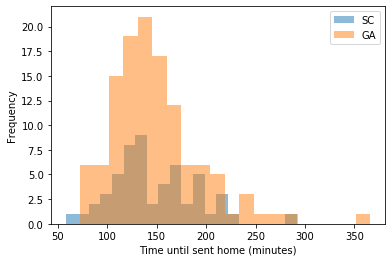

In [8]:
SC.time_until_sent_home.plot.hist(bins=20, alpha=0.5)
GA.time_until_sent_home.plot.hist(bins=20, alpha=0.5)
_ = plt.legend(['SC', 'GA'])
_ = plt.xlabel('Time until sent home (minutes)')
_ = plt.show()

In [9]:
# Export data examples
SC.to_csv('SC_emergency_room.csv', index=False)
GA.to_csv('GA_emergency_room.csv', index=False)
import_state_info('MN').to_csv('MN_emergency_room.csv', index=False)